# Example of using the PyRadiomics toolbox in Python

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

In [1]:
from __future__ import print_function
import six
import glob, os, sys  # needed navigate the system to get the input data

# features are described at https://pyradiomics.readthedocs.io/en/latest/features.html
import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

import SimpleITK as sitk
import numpy as np
import pandas as pd

### Setting up data

Test cases can be downloaded to temporary files. This is handled by the `radiomics.getTestCase()` function, which checks if the requested test case is available and if not, downloads it. It returns a tuple with the location of the image and mask of the requested test case, or (None, None) if it fails.

Alternatively, if the data is available somewhere locally, this directory can be passed as a second argument to `radiomics.getTestCase()`. If that directory does not exist or does not contain the testcase, functionality reverts to default and tries to download the test data.

If getting the test case fails, PyRadiomics will log an error explaining the cause.

In [2]:
os.getcwd()

'/home/pablo/dev/radioterapia/fluence_maps/radiomics'

### Create mask file _mask.nrrd_

In [3]:
def createMask(image, maskPath):
    point = (int(image_size[0]/2), int(image_size[1]/2))  # fill in the index of your point here
    # (254, 254) excluyo 1 pixel de cada lado
    roi_size = (image_size[0]-2, image_size[1]-2)  # x, y, z; uneven to ensure the point is really the center of your ROI

    ma_arr = np.zeros(image_size, dtype='uint8')

    # Compute lower and upper bound of the ROI
    L_x = point[0] - int((roi_size[0]) / 2)
    L_y = point[1] - int((roi_size[1]) / 2)

    U_x = point[0] + int((roi_size[0] - 1) / 2)
    U_y = point[1] + int((roi_size[1] - 1) / 2)

    # ensure the ROI stays within the image bounds
    L_x = max(0, L_x)
    L_y = max(0, L_y)

    U_x = min(image_size[1] - 1, U_x)
    U_y = min(image_size[0] - 1, U_y)

    print(L_x, L_y, U_x, U_y)

    # 'segment' the mask
    ma_arr[L_y:U_y + 1, L_x:U_x+1] = 1  # Add + 1 to each slice, as slicing is done from lower bound to, but not including, upper bound. Because we do want to include our upper bound, add + 1
    print(ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)
    ma.CopyInformation(image)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

    sitk.WriteImage(ma, maskPath, True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks

In [4]:
ARG_SOURCE_PATH='/hdd/data/radioterapia/ciolaplata'
ARG_DICOM_AND_GAMMA_CSV = "codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv" # 7244 casos
ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.texture-features.csv'

image_filename = '1.3.6.1.4.1.9590.100.1.2.104687111612620525338811872261145275128.jpeg'
# image_filename = '1.3.6.1.4.1.9590.100.1.2.413026936412366497424912997123899479271.jpeg'
imagePath = os.path.join(ARG_SOURCE_PATH, '2017-opencv-jpeg', image_filename)
mask_filename = 'mask.nrrd'
ARG_MASK_PATH = os.path.join(ARG_SOURCE_PATH, mask_filename)

In [5]:
image_1 = sitk.ReadImage(imagePath)
# [::-1] es iterable[inicio:fin:paso]
image_size = image_1.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x
print(image_size)

# uncomment if you need to recreate mask file 'mask.nrrd'
# createMask(image_1, maskPath)

(256, 256)


In [6]:
label_1 = sitk.ReadImage(ARG_MASK_PATH)
image_size = label_1.GetSize()[::-1]
print(image_size)

(256, 256)


### Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

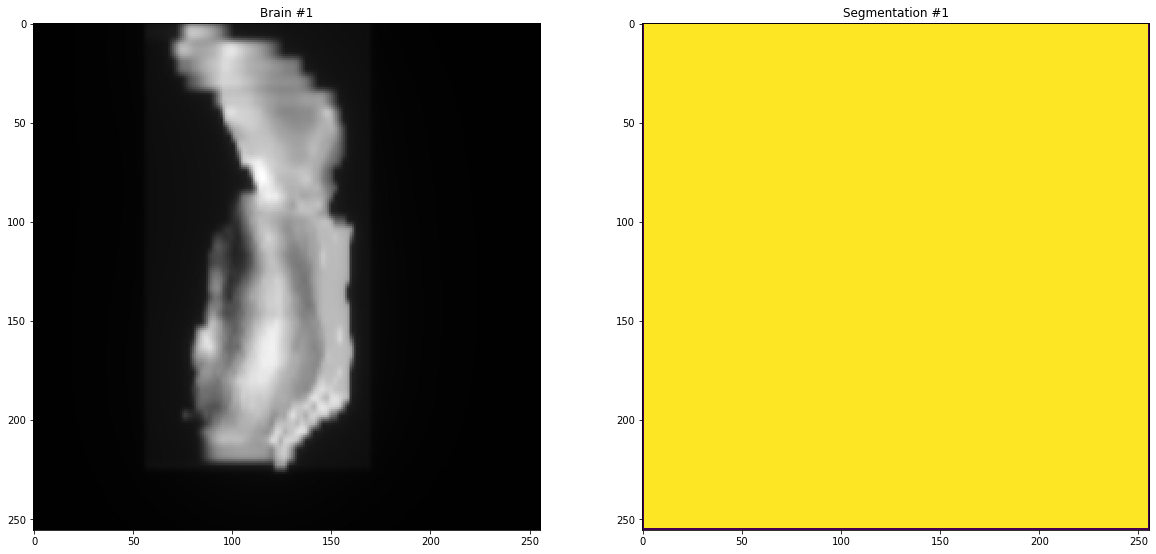

In [7]:
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

# 1 row, 2 columns, plot 1
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[:,:], cmap="gray")
plt.title("Brain #1")
# 1 row, 2 columns, plot 2
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[:,:])        
plt.title("Segmentation #1")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object from the parameters set in `Params.yaml`.  Then generate features for the two images.

In [8]:
# Additonally, store the location of the example parameter file, stored in \pyradiomics\examples/exampleSettings
paramPath = os.path.join('.', 'rtParams.yaml')
print('Parameter file, absolute path:', os.path.abspath(paramPath))

Parameter file, absolute path: /home/pablo/dev/radioterapia/fluence_maps/radiomics/rtParams.yaml


### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are three possibilities:

1. Use defaults, don't define custom settings

2. Define parameters in a dictionary, control filters and features after initialisation

3. Use a parameter file

##### Method 3, using a parameter file

In [9]:
# radiomics.setVerbosity(10) # 10: Log messages of level “DEBUG” and up are printed (i.e. all log messages)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'MeanAbsoluteDeviation', 'Mean', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance'], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'MCC', 'Idmn', 'Id', 'Idn', 'InverseVarianc

### Extract features

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [10]:
result = extractor.execute(imagePath, ARG_MASK_PATH)

In [11]:
print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
print('')
print('Calculated features')
for key, value in six.iteritems(result):
    print('\t', key, ':', value)

Result type: <class 'collections.OrderedDict'>

Calculated features
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.18.1
	 diagnostics_Versions_SimpleITK : 2.0.2
	 diagnostics_Versions_PyWavelet : 1.1.1
	 diagnostics_Versions_Python : 3.7.5
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : ab636049276bca74c316ed609b655d4bca28c476
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 diagnostics_Image-original_Size : (256, 256)
	 diagnostics_Image-o

## Extract features for each .jpeg file in folder and generate .csv with features

In [12]:
def getFeatureNames(result):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    # le dejo el prefijo 'original_' y se lo saco después
    feature_names = [key for key in result.keys() if key.startswith('original_')]
    return feature_names

In [13]:
def getRenamedFeatureNames(result):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # remuevo el prefijo 'original_'
    feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    return feature_names

In [14]:
getFeatureNames(result)[:5]

['original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange']

In [15]:
def build_jpeg_filename(base, year, filename):
    return os.path.join(base, year + '-opencv-jpeg', filename + '.jpeg')

In [16]:
source_folder = ARG_SOURCE_PATH

gamma_csv = os.path.join(source_folder, ARG_DICOM_AND_GAMMA_CSV)
df_dcm_in = pd.read_csv(gamma_csv, sep=';', delimiter=None, header=0)
N = len(df_dcm_in)
feature_names = getFeatureNames(result)
print("Se extraerán {} features para cada uno de los {} archivos JPEG en {}.".format(len(feature_names), N, gamma_csv))

# agrego una columna constante al dataframe para hacer más simple el armado del full file path de los archivos dicom
df_dcm_in['base_dir'] = source_folder

df_features_out = pd.DataFrame(columns=['jpeg_full_filepath', 'gamma_index'] + feature_names)
df_features_out['jpeg_full_filepath'] = [build_jpeg_filename(row[0], str(row[1]), row[2]) for row in df_dcm_in[['base_dir', 'año', 'fluencia calculada']].values]
df_features_out['gamma_index'] = df_dcm_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)


# df_features_out.loc[:, ['jpeg_full_filepath','gamma_index','firstorder_10Percentile','glszm_LowGrayLevelZoneEmphasis']]
df_features_out[['jpeg_full_filepath','gamma_index','original_firstorder_10Percentile','original_glszm_LowGrayLevelZoneEmphasis']]

Se extraerán 70 features para cada uno de los 7244 archivos JPEG en /hdd/data/radioterapia/ciolaplata/codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv.


,jpeg_full_filepath,gamma_index,original_firstorder_10Percentile,original_glszm_LowGrayLevelZoneEmphasis
0,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.161700,NaN,NaN
1,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.333400,NaN,NaN
2,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.338600,NaN,NaN
3,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.513800,NaN,NaN
4,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.604800,NaN,NaN
...,...,...,...,...
7239,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.908812,NaN,NaN
7240,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.916852,NaN,NaN
7241,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.922824,NaN,NaN
7242,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.935760,NaN,NaN


In [17]:
def extractFeatures(df):
    i = 0
    for file in df['jpeg_full_filepath'].values:
        try:
            image = sitk.ReadImage(file)
            shape = image.GetSize()[::-1]
            assert len(shape) == 2, "JPEG files are not grey level (i.e.: do not have 2 channels)"
            assert shape[0] == 256 and shape[1] == 256, "JPEG files are not of size 256x256"

            result = extractor.execute(file, ARG_MASK_PATH)

            for key in result.keys():
                if key.startswith('original_'):
                    df.loc[i, key] = result.get(key)

            sys.stdout.write('\r>> Features extracted for image %d/%d.' % (i+1, N))
            sys.stdout.flush()
            i += 1

        except OSError as err:
            print('Could not extract features for file {}, error: {}'.format(file, err))

    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return df

In [18]:
# extract features
df_features = extractFeatures(df_features_out)

>> Features extracted for image 7244/7244.


In [19]:
renamed_feature_names = getRenamedFeatureNames(result)
df_features.columns= ['jpeg_full_filepath', 'gamma_index'] + renamed_feature_names
df_features

,jpeg_full_filepath,gamma_index,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_MeanAbsoluteDeviation,firstorder_Mean,...,glszm_LargeAreaLowGrayLevelEmphasis,glszm_LowGrayLevelZoneEmphasis,glszm_SizeZoneNonUniformity,glszm_SizeZoneNonUniformityNormalized,glszm_SmallAreaEmphasis,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance
0,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.161700,1.0,108.0,169714246.0,1.4099668060571284,8.0,8.201475983994603,31.090190976680546,21.68246636493273,...,18412853.63126466,0.038143744679409716,12.780821917808218,0.08753987614937137,0.284184282243166,21.398754857562796,0.00820286917845313,6.307166877779862,0.002263004526009052,18284934.385250516
1,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.333400,0.0,98.0,139138467.0,1.3265745893768908,11.0,7.720804450417229,28.891244377488444,20.23217496434993,...,10611084.026083378,0.035058425505664105,42.4863813229572,0.16531665884419144,0.4101946107789902,23.052194267636054,0.01164101921119983,6.144632911246399,0.003983507967015934,10591511.302275583
2,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.338600,0.0,58.0,99913634.0,1.0056413098839287,3.0,15.40568021812979,21.145489231892345,13.831979663959327,...,19098110.883015852,0.04218217443694176,21.206060606060607,0.12852157943067033,0.34900973415754954,22.696817019337146,0.010659346426244526,6.3553525175762395,0.00255750511501023,18978975.436326906
3,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.513800,0.0,83.0,128906260.0,1.4403754213958582,10.0,9.25193291475379,27.33505792072034,19.378820757641517,...,15239908.532790173,0.044931445717149236,9.709302325581396,0.05644943212547323,0.1920710663306093,9.325578546748734,0.011426108378140863,6.693629472909357,0.002666005332010664,15153645.119253648
4,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.604800,0.0,78.0,117370763.0,1.2170824741592532,4.0,10.936359675711412,24.376302539324655,16.824028148056296,...,11212843.67130925,0.04422711718563537,49.44961240310077,0.19166516435310377,0.4265758932009582,31.664259223217723,0.02301807520794114,6.251086099571799,0.003999007998015996,11189028.453518417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7239,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.908812,0.0,9.0,83280566.0,0.5839114231516503,1.0,25.537757159198886,14.73919034526642,8.897885795771591,...,13926460.707283225,0.029722795310846734,43.16030534351145,0.16473398986073073,0.38390547196187796,29.900732634602903,0.007907035864467591,6.229953841423585,0.004061008122016244,13868246.650253478
7240,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.916852,0.0,11.0,74654133.0,0.6620838884920056,1.0,23.457868249282825,14.848130473789002,9.020723541447083,...,18626862.194314227,0.04492913099414065,20.94764397905759,0.1096735286861654,0.28418886607665456,15.63092374703073,0.013573974545216973,6.382209622535514,0.002960505921011842,18518657.396672238
7241,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.922824,0.0,16.0,117385116.0,0.8412555632051395,2.0,16.51682310880761,20.411124723111246,12.907185814371628,...,10930709.939633803,0.04396025093956946,45.71009771986971,0.148892826449087,0.3599711213325554,19.458976456087345,0.018278862260935853,6.406146665227865,0.004758509517019034,10896082.368428314
7242,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.935760,0.0,1.0,13096240.0,0.22980086152539425,0.0,148.4783266692175,3.673610912476955,2.020770041540083,...,32285240.533921566,0.04629622173019707,16.203252032520325,0.13173375636195386,0.33817419725518916,18.099960998038547,0.01167972713277226,5.9767097287581485,0.001906503813007626,32011949.891863313


In [20]:
texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
df_features.to_csv(texture_features_csv, index=False)
print(f'Texture features .csv file saved to {texture_features_csv}.\n')

Texture features .csv file saved to /hdd/data/radioterapia/ciolaplata/2019-2018-2017.texture-features.csv.

